##### <p> Samuel Wolfe <br> July 3rd, 2023 <br> MSBA 206 <br> DMBA Chapter 6 Homework 6.3 & 6.4 </p>

In [11]:
#setting up core functions
import pandas as pd
import requests
import io
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, BayesianRidge
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pylab as plt
from dmba import adjusted_r2_score, AIC_score, BIC_score

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import liftChart
from dmba import adjusted_r2_score, AIC_score

def readFile(url):
    download = requests.get(url).content
    # Reading the downloaded content and turning it into a pandas dataframe
    df = pd.read_csv(io.StringIO(download.decode('utf-8')))
    return df
def normalize(df):
    dfNorm = (df - df.mean(numeric_only=True)) / df.std(numeric_only=True)
    dfNorm = dfNorm.dropna(axis=1)
    return dfNorm
def correlate(df):
    dfCorr = df.corr(numeric_only=True)
    return dfCorr
def statslist(df):
    dfStats = pd.DataFrame({'Mean' : df.mean(numeric_only=True),
            'SD' : df.std(numeric_only=True),
            'Min' : df.min(), 
            'Max' : df.max(),
            'Median' : df.median(numeric_only=True),
            })
    return dfStats

#Forward Selection air
def air_train_model_forward(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(airTrain_X[variables], airTrain_y)
    return model

def air_score_model_forward(model, variables):
    if len(variables) == 0:
        return AIC_score(airTrain_y, [airTrain_y.mean()] * len(airTrain_y), model, df=1)
    return AIC_score(airTrain_y, model.predict(airTrain_X[variables]), model)

#Forward Selection car
def car_train_model_forward(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(carTrain_X[variables], carTrain_y)
    return model

def car_score_model_forward(model, variables):
    if len(variables) == 0:
        return AIC_score(carTrain_y, [carTrain_y.mean()] * len(carTrain_y), model, df=1)
    return AIC_score(carTrain_y, model.predict(carTrain_X[variables]), model)

#exhaustive search air
def air_train_model_exhaustive(variables):
    model = LinearRegression()
    model.fit(airTrain_X[variables], airTrain_y)
    return model

def air_score_model_exhaustive(model, variables):
    pred_y = model.predict(airTrain_X[variables])
    # we negate as score is optimized to be as low as possible
    return -adjusted_r2_score(airTrain_y, pred_y, model)

#exhaustive search car
def car_train_model_exhaustive(variables):
    model = LinearRegression()
    model.fit(carTrain_X[variables], carTrain_y)
    return model

def car_score_model_exhaustive(model, variables):
    pred_y = model.predict(carTrain_X[variables])
    # we negate as score is optimized to be as low as possible
    return -adjusted_r2_score(carTrain_y, pred_y, model)

#Made this one to extract the best variables list from an exhaustive search.
def exhaustivePred(dfTrans):
    predList = []
    for x in dfTrans.index:
        if dfTrans.loc[x][13] == True:
            predList.append(x)
    return predList

# 6.3

## 6.3.a.
When looking at the numerical predictors compared to the target variable of FARE we see the following. (See code below for Correlation and Plots)<br>&emsp; &emsp; &emsp;
The correlation chart gives us Distance as the highest followed by Coupon.


In [12]:
dfAF= readFile("https://raw.githubusercontent.com/wolfesamk/MSBA-206/main/dmba/Airfares.csv") # Make sure the url is the raw version of the file on GitHub
targetVar = 'FARE'
dfAFCorr = correlate(dfAF)
dfAFCorrTgta = dfAFCorr.loc[targetVar].sort_values(ascending=False)
dfAFCorrTgta = dfAFCorrTgta[dfAFCorrTgta < 1]
print(dfAFCorrTgta)


DISTANCE    0.670016
COUPON      0.496537
E_INCOME    0.326092
E_POP       0.285043
S_INCOME    0.209135
S_POP       0.145097
NEW         0.091730
HI          0.025195
PAX        -0.090705
Name: FARE, dtype: float64


In [13]:
colact = 3
rowact = 3
fig, ax = plt.subplots(rowact, colact, figsize=(20, 20))
#plt.subplots_adjust(wspace=0.5)
rowbase=0
colbase=0
listdf = dfAF.select_dtypes([np.number]).columns
lendf = 0
while rowbase < rowact:
    while colbase < colact:
        sns.scatterplot(data=dfAF.select_dtypes([np.number]), ax=ax[rowbase,colbase], x=targetVar, y=dfAF.select_dtypes([np.number])[listdf[lendf]])
        ax[rowbase,colbase].set_xlabel(targetVar)
        colbase = colbase + 1
        lendf = lendf + 1
        if lendf > 8:
            break
    rowbase = rowbase + 1
    colbase = 0

plt.show()

## 6.3.b.
Referencing that one question of interest is if the presence or absence of Southwest (SW) has an impact on FARE,<br>&emsp; &emsp; &emsp;
I resorted the categories to emphasize this interest. We can see immediately that SW NOT being at the airport<br>&emsp; &emsp; &emsp;
has the largest impact on the average of FARE.<br>&emsp; &emsp; &emsp;
I would say it is safe to say SW is the best Categorical Variable for predicting FARE.

In [14]:
#6.3.b
dfAFCat = dfAF.select_dtypes(object).join(dfAF['FARE']).iloc[: , 4:]
dfAFCat
ptAF = pd.pivot_table(dfAFCat, values=targetVar, index=dfAFCat.select_dtypes(object), aggfunc=np.mean).sort_values(by=targetVar, ascending = False)
ptAF

FARE
VACATION SW  SLOT       GATE                   
No       No  Free       Constrained  210.581667
             Controlled Free         208.329825
                        Constrained  206.797778
             Free       Free         196.183782
Yes      No  Free       Free         143.976716
No       Yes Free       Constrained  139.960000
Yes      No  Controlled Free         139.901786
             Free       Constrained  137.313500
         Yes Controlled Free         131.605000
No       Yes Controlled Free         110.170588
             Free       Free          96.951491
Yes      Yes Free       Free          89.811176
No       Yes Controlled Constrained   74.280000

## 6.3
C.<br>&emsp;
i.      See code below.<br>&emsp;
ii.     See code below.<br>&emsp;
iii.     See code below.<br>&emsp; &emsp;
        They appear to both provide the same results. Stepwise was faster.<br>&emsp;
iv.     At least with what I am seeing both models have the same results, everything will be the same<br>&emsp; &emsp;
        between ii and iii. There are clear differences in the predictive capability of the raw predictors<br>&emsp; &emsp;
        and ii/iii, but that is to be expected.
v.      251.72 vs raw data mean of 144.60. Code below.<br>&emsp;
vi.     251.72-208.69=43.03 price reduction with Southwest set to True.<br>&emsp;
vii.    HI, PAX, and NEW are determined from the routes, would not be available prior.<br>&emsp; &emsp;
        DISTANCE, VACATION, SLOT, GATE, COUPON, SW, Incomes, and Population metrics can be created easily prior. <br>&emsp; &emsp;
        These statistics are generated by using existing airport data and comparing it to the new airport. <br>&emsp;
ix.     253.43 average fare. <br>&emsp;
x.      Just comparing the RMSE the model from iii has better metrics of 34.88/36.11 vs viii 38.16/40.23. <br>&emsp; &emsp;
        Looking at the predicted values we find that viii over predicts the fare of the dummy route used in v and viii. <br>&emsp; &emsp;
        The model from viii is good enough for initial predictions. It evaluates almost as well as iii but without using <br>&emsp; &emsp;
        data not available until after the airport has been open for some time. It would be best to use the viii model <br>&emsp; &emsp;
        in the beginning and then transition to iii after the airport has been open long enough to gather the missing <br>&emsp; &emsp;
        statistics.

# 6.3.c.i

In [15]:
#6.3.c.i Convert to dummy and split into test groups.
# partition data
Xair = pd.get_dummies(dfAF.iloc[: , 4:].drop(columns='FARE'),drop_first=True)
yair = dfAF[targetVar]
airTrain_X, airValid_X, airTrain_y, airValid_y = train_test_split(Xair, yair, test_size=0.4, random_state=1)

airModel1 = LinearRegression()
airModel1.fit(airTrain_X, airTrain_y)
pred1 = pd.DataFrame(airModel1.predict(airValid_X), columns=['P_FARE'])
regressionSummary(airValid_y, airModel1.predict(airValid_X))


Regression statistics

                      Mean Error (ME) : -1.8231
       Root Mean Squared Error (RMSE) : 36.0002
            Mean Absolute Error (MAE) : 28.5002
          Mean Percentage Error (MPE) : -6.6037
Mean Absolute Percentage Error (MAPE) : 21.6048


# 6.3.c.ii

In [16]:
#6.3.c.ii stepwise regression
iiBest_model, iiBest_variables = stepwise_selection(airTrain_X.columns, air_train_model_forward, air_score_model_forward, verbose=True)
print('These are the best variables: \n', iiBest_variables)
regressionSummary(airValid_y, iiBest_model.predict(airValid_X[iiBest_variables]))

Variables: COUPON, NEW, HI, S_INCOME, E_INCOME, S_POP, E_POP, DISTANCE, PAX, VACATION_Yes, SW_Yes, SLOT_Free, GATE_Free
Start: score=4379.42, constant
Step: score=4149.88, add DISTANCE
Step: score=4025.89, add SW_Yes
Step: score=3913.59, add VACATION_Yes
Step: score=3890.27, add HI
Step: score=3873.33, add GATE_Free
Step: score=3852.81, add SLOT_Free
Step: score=3850.30, add PAX
Step: score=3844.58, add E_POP
Step: score=3826.43, add S_POP
Step: score=3821.88, add E_INCOME
Step: score=3821.88, unchanged None
These are the best variables: 
 ['DISTANCE', 'SW_Yes', 'VACATION_Yes', 'HI', 'GATE_Free', 'SLOT_Free', 'PAX', 'E_POP', 'S_POP', 'E_INCOME']

Regression statistics

                      Mean Error (ME) : -1.8591
       Root Mean Squared Error (RMSE) : 36.1129
            Mean Absolute Error (MAE) : 28.5252
          Mean Percentage Error (MPE) : -6.7084
Mean Absolute Percentage Error (MAPE) : 21.7198


# 6.3.c.iii

In [144]:
#This cell takes 13.3s
#6.3.c.iii
iiiAllVariables = airTrain_X.columns
iiiResults = exhaustive_search(iiiAllVariables, air_train_model_exhaustive, air_score_model_exhaustive)

iiiData = []
for result in iiiResults:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(airTrain_y, model.predict(airTrain_X[variables]), model)
    
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in iiiAllVariables})
    iiiData.append(d)



In [145]:
pd.set_option('display.width', 200)
dfViiiExhaust = pd.DataFrame(iiiData, columns=('n', 'r2adj', 'AIC') + tuple(sorted(iiiAllVariables)))
print(dfViiiExhaust)
#print(dfViiiExhaust.sort_values(by=['AIC'],ascending=True))
#print(dfViiiExhaust.sort_values(by=['AIC'],ascending=True).head(1))
pd.reset_option('display.width')

     n     r2adj          AIC  COUPON  DISTANCE  E_INCOME  E_POP  GATE_Free     HI    NEW    PAX  SLOT_Free  SW_Yes  S_INCOME  S_POP  VACATION_Yes
0    1  0.453107  4149.881509   False      True     False  False      False  False  False  False      False   False     False  False         False
1    2  0.605715  4025.892420   False      True     False  False      False  False  False  False      False    True     False  False         False
2    3  0.706909  3913.585125   False      True     False  False      False  False  False  False      False    True     False  False          True
3    4  0.724977  3890.268211   False      True     False  False      False   True  False  False      False    True     False  False          True
4    5  0.737584  3873.328296   False      True     False  False       True   True  False  False      False    True     False  False          True
5    6  0.751947  3852.808698   False      True     False  False       True   True  False  False       True    True   

# 6.3.c.iv

In [146]:
#6.3.c.iv.
ivPredictors = iiBest_variables
outcome = targetVar

Xiv = airTrain_X[ivPredictors]
yiv = airTrain_y

# fit the regression model y on x
airBest_lm = LinearRegression()
airBest_lm.fit(Xiv,yiv)

# print coefficients
print('intercept ', airBest_lm.intercept_)
print(pd.DataFrame({'Predictor': Xiv.columns, 'coefficient': airBest_lm.coef_}))

# print performance measures (training set)
print("\nModel performance on training data:")
regressionSummary(airTrain_y, airBest_lm.predict(airTrain_X[ivPredictors]))

# predict prices in validation set, print first few predicted/actual values and residuals
best_lm_pred = airBest_lm.predict(airValid_X[ivPredictors])

# print performance measures (validation set)
print("\nModel performance on validation data:")
regressionSummary(airValid_y, best_lm_pred)

intercept  52.89100014950026
      Predictor  coefficient
0      DISTANCE     0.075558
1        SW_Yes   -43.031272
2  VACATION_Yes   -35.865596
3            HI     0.007188
4     GATE_Free   -21.410803
5     SLOT_Free   -13.915304
6           PAX    -0.000829
7         E_POP     0.000004
8         S_POP     0.000004
9      E_INCOME     0.001148

Model performance on training data:

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 34.8867
            Mean Absolute Error (MAE) : 27.1374
          Mean Percentage Error (MPE) : -4.5313
Mean Absolute Percentage Error (MAPE) : 20.1672

Model performance on validation data:

Regression statistics

                      Mean Error (ME) : -1.8591
       Root Mean Squared Error (RMSE) : 36.1129
            Mean Absolute Error (MAE) : 28.5252
          Mean Percentage Error (MPE) : -6.7084
Mean Absolute Percentage Error (MAPE) : 21.7198


In [17]:
airTrain_df = airTrain_X.join(airTrain_y)
airValid_df = airValid_X.join(airValid_y)

airAllPredictors = airTrain_X.columns
formulaRaw = 'FARE ~ ' + ' + '.join(airAllPredictors)
formulaTrain = 'FARE ~ ' + ' + '.join(iiBest_variables)

airRaw_lm = smf.ols(formula=formulaRaw, data=airTrain_df).fit()
airTrain_lm = smf.ols(formula=formulaTrain, data=airTrain_df).fit()
print(airRaw_lm.summary())
print(airTrain_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                   FARE   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     101.0
Date:                Wed, 05 Jul 2023   Prob (F-statistic):          1.21e-112
Time:                        16:54:26   Log-Likelihood:                -1897.6
No. Observations:                 382   AIC:                             3823.
Df Residuals:                     368   BIC:                             3878.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               52.9728 

In [18]:
airRaw_lm_pred = airRaw_lm.predict(airValid_X)
airTrain_lm_pred = airTrain_lm.predict(airValid_X)

resultPredRaw = pd.DataFrame({'Predicted': airRaw_lm_pred, 'Actual': airValid_y,
                       'Residual': airValid_y - airRaw_lm_pred})
resultPredTrain = pd.DataFrame({'Predicted': airTrain_lm_pred, 'Actual': airValid_y,
                       'Residual': airValid_y - airTrain_lm_pred})



# Compute common accuracy measures
print('Raw')
regressionSummary(airValid_y, airRaw_lm_pred)
print(resultPredRaw.sort_values(by='Predicted',ascending=False).head(5))
print('\n\nBest Values')
regressionSummary(airValid_y, airTrain_lm_pred)
print(resultPredTrain.sort_values(by='Predicted',ascending=False).head(5))

Raw

Regression statistics

                      Mean Error (ME) : -1.8231
       Root Mean Squared Error (RMSE) : 36.0002
            Mean Absolute Error (MAE) : 28.5002
          Mean Percentage Error (MPE) : -6.6037
Mean Absolute Percentage Error (MAPE) : 21.6048
      Predicted  Actual   Residual
474  324.804199  367.72  42.915801
162  316.438512  301.79 -14.648512
523  314.150454  289.25 -24.900454
521  306.497788  289.25 -17.247788
488  305.238415  374.40  69.161585


Best Values

Regression statistics

                      Mean Error (ME) : -1.8591
       Root Mean Squared Error (RMSE) : 36.1129
            Mean Absolute Error (MAE) : 28.5252
          Mean Percentage Error (MPE) : -6.7084
Mean Absolute Percentage Error (MAPE) : 21.7198
      Predicted  Actual   Residual
474  322.922574  367.72  44.797426
162  311.989227  301.79 -10.199227
523  307.396257  289.25 -18.146257
333  305.032866  293.21 -11.822866
488  302.587059  374.40  71.812941


In [19]:
liftChart(resultPredTrain.sort_values(by=['Predicted'], ascending=False).Predicted, labelBars=True, title='Refined Predictors')
plt.tight_layout()
plt.show()

# 6.3.c.v

In [150]:
#6.3.c.v
airV = {'COUPON':[1.202],'NEW':[3],'HI':[4442.141],'S_INCOME':[28760],'E_INCOME':[27664],'S_POP':[4557004],'E_POP':[3195503],'DISTANCE':[1976],'PAX':[12782],'VACATION_Yes':[False],'SW_Yes':[False],'SLOT_Free':[True],'GATE_Free':[True]}
dfairV = pd.DataFrame(data=airV)
air_lm_pred = airTrain_lm.predict(dfairV)

result = pd.DataFrame({'Predicted': air_lm_pred, 'Data Mean': 144.60,
                       'Residual': 144.60 - air_lm_pred})
print(result.head(1))

    Predicted  Data Mean    Residual
0  251.721531      144.6 -107.121531


# 6.3.c.vi

In [151]:
#6.3.c.vi
airV = {'COUPON':[1.202],'NEW':[3],'HI':[4442.141],'S_INCOME':[28760],'E_INCOME':[27664],'S_POP':[4557004],'E_POP':[3195503],'DISTANCE':[1976],'PAX':[12782],'VACATION_Yes':[False],'SW_Yes':[True],'SLOT_Free':[True],'GATE_Free':[True]}
dfairV = pd.DataFrame(data=airV)
air_lm_pred = airTrain_lm.predict(dfairV)

result = pd.DataFrame({'Predicted': air_lm_pred, 'Data Mean': 144.60,
                       'Residual': 144.60 - air_lm_pred})
print(result.head(1))

    Predicted  Data Mean   Residual
0  208.690259      144.6 -64.090259


# 6.3.c.viii

In [152]:
viiiVar = ['COUPON', 'S_INCOME', 'E_INCOME', 'S_POP', 'E_POP', 'DISTANCE', 'VACATION_Yes', 'SW_Yes', 'SLOT_Free', 'GATE_Free']
resultsViii = exhaustive_search(viiiVar, air_train_model_exhaustive, air_score_model_exhaustive)

dataViii = []
for result in resultsViii:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(airTrain_y, model.predict(airTrain_X[variables]), model)
    
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in viiiVar})
    dataViii.append(d)

In [153]:
pd.set_option('display.width', 200)
dfViiiExhaust = pd.DataFrame(dataViii, columns=('n', 'r2adj', 'AIC') + tuple(sorted(viiiVar)))
print(dfViiiExhaust.sort_values(by=['AIC'],ascending=True).head(1))
pd.reset_option('display.width')

   n     r2adj          AIC  COUPON  DISTANCE  E_INCOME  E_POP  GATE_Free  SLOT_Free  SW_Yes  S_INCOME  S_POP  VACATION_Yes
5  6  0.731941  3882.437877   False      True      True  False       True       True    True     False  False          True


In [154]:
viiiPredictors = ['E_INCOME','DISTANCE', 'VACATION_Yes', 'SW_Yes', 'SLOT_Free', 'GATE_Free']

In [155]:
Xviii = airTrain_X[viiiPredictors]
yviii = airTrain_y

# fit the regression model y on x
viii_lm = LinearRegression()
viii_lm.fit(Xviii,yviii)

# print coefficients
print('intercept ', viii_lm.intercept_)
print(pd.DataFrame({'Predictor': Xviii.columns, 'coefficient': viii_lm.coef_}))

# print performance measures (training set)
print("\nModel performance on training data:")
regressionSummary(airTrain_y, viii_lm.predict(airTrain_X[viiiPredictors]))

# predict prices in validation set, print first few predicted/actual values and residuals
viii_lm_pred = viii_lm.predict(airValid_X[viiiPredictors])

# print performance measures (validation set)
print("\nModel performance on validation data:")
regressionSummary(airValid_y, viii_lm_pred)

intercept  116.69083767592343
      Predictor  coefficient
0      E_INCOME     0.001185
1      DISTANCE     0.073214
2  VACATION_Yes   -48.644853
3        SW_Yes   -49.831845
4     SLOT_Free   -13.815639
5     GATE_Free   -26.885524

Model performance on training data:

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 38.1621
            Mean Absolute Error (MAE) : 30.1802
          Mean Percentage Error (MPE) : -5.4799
Mean Absolute Percentage Error (MAPE) : 21.9127

Model performance on validation data:

Regression statistics

                      Mean Error (ME) : -0.9244
       Root Mean Squared Error (RMSE) : 40.2294
            Mean Absolute Error (MAE) : 31.9391
          Mean Percentage Error (MPE) : -7.0825
Mean Absolute Percentage Error (MAPE) : 23.5055


# 6.3.c.ix

In [156]:
#6.3.c.ix
airV = {'COUPON':[1.202],'NEW':[3],'HI':[4442.141],'S_INCOME':[28760],'E_INCOME':[27664],'S_POP':[4557004],'E_POP':[3195503],'DISTANCE':[1976],'PAX':[12782],'VACATION_Yes':[False],'SW_Yes':[False],'SLOT_Free':[True],'GATE_Free':[True]}
dfairV = pd.DataFrame(data=airV)
ix_lm_pred = viii_lm.predict(dfairV[viiiPredictors])

result = pd.DataFrame({'Predicted': ix_lm_pred, 'Data Mean': 144.60,
                       'Residual': 144.60 - ix_lm_pred})
print(result.head(1))

    Predicted  Data Mean    Residual
0  253.434984      144.6 -108.834984


## 6.3.d.
The analysis would have to focus on the impact of SW on the outcome rather than FARE in the beginning. <br>&emsp; &emsp; &emsp;
My first step in changing my analysis would be to run the initial correlation on SW instead of FARE.<br>&emsp; &emsp; &emsp;
Overall for the analysis, the regression analysis was able to point out that areas with SW had lower fares. <br>&emsp; &emsp; &emsp;
This is unsurprising. The next step would be to gather publicly available data or purchase data on SW as an<br>&emsp; &emsp; &emsp;
entity to examine and compare its data vs its competitors.

# 6.4

##### Below I am preparing the dataset per the text.

In [202]:
#Splitting the Data
dfCar= readFile(r'E:\Aliit\School\MSBA\206\dmba-datasets\ToyotaCorolla.csv')
targetVar = 'Price'
predictors = ['Age_08_04','KM','Fuel_Type','HP','Automatic','Doors','Quarterly_Tax','Mfr_Guarantee','Guarantee_Period',
              'Airco','Automatic_airco','CD_Player','Powered_Windows','Sport_Model','Tow_Bar']
outcome = 'Price'

# partition data
Xcar = pd.get_dummies(dfCar[predictors], drop_first=True)
ycar = dfCar[targetVar]

carTrain_X, carTemp_X, carTrain_y, carTemp_y = train_test_split(Xcar, ycar, test_size=0.5, random_state=1)
carValid_X, carTest_X, carValid_y, carTest_y = train_test_split(carTemp_X, carTemp_y, test_size=0.4, random_state=1)

#### Below I am running an exhaustive search to get the best results.

In [158]:
#This section takes 1m 36.7s
carAllVariables = carTrain_X.columns
carResults = exhaustive_search(carAllVariables, car_train_model_exhaustive, car_score_model_exhaustive)

carData = []
for result in carResults:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(carTrain_y, model.predict(carTrain_X[variables]), model)
    
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in carAllVariables})
    carData.append(d)


#### Below I am finding the best AIC value and extracting the list. 
##### NOTE: I made the function exhaustivePred to enable extraction of the best predictors. MUCH EASIER! Feel free to use, though I suspect you have your own methods! It can be found towards the bottom of the top section.

In [277]:
dfCarExhaust = pd.DataFrame(carData, columns=('n', 'r2adj', 'AIC') + tuple(sorted(carAllVariables)))
pd.set_option('display.width', 250)
print(dfCarExhaust.sort_values(by=['AIC'],ascending=True).head(1))
pd.reset_option('display.width')
carCol = dfCarExhaust.iloc[13:14 , 3:].T
#listify!
carBestPred = exhaustivePred(carCol)

     n     r2adj           AIC  Age_08_04  Airco  Automatic  Automatic_airco  CD_Player  Doors  Fuel_Type_Diesel  Fuel_Type_Petrol  Guarantee_Period    HP    KM  Mfr_Guarantee  Powered_Windows  Quarterly_Tax  Sport_Model  Tow_Bar
13  14  0.890673  12295.119559       True  False       True             True       True   True              True              True              True  True  True          False             True           True         True     True


# 6.4.a
See code below for the data. <br>
Looking at the print out, Age_08_04, Automatic_airco, HP, and KM are the top 4 variables.


In [278]:
pd.set_option('display.width', 250)
print(dfCarExhaust.head(7))
pd.reset_option('display.width')

   n     r2adj           AIC  Age_08_04  Airco  Automatic  Automatic_airco  CD_Player  Doors  Fuel_Type_Diesel  Fuel_Type_Petrol  Guarantee_Period     HP     KM  Mfr_Guarantee  Powered_Windows  Quarterly_Tax  Sport_Model  Tow_Bar
0  1  0.767948  12822.658298       True  False      False            False      False  False             False             False             False  False  False          False            False          False        False    False
1  2  0.822266  12632.183882       True  False      False             True      False  False             False             False             False  False  False          False            False          False        False    False
2  3  0.843045  12543.911249       True  False      False             True      False  False             False             False             False   True  False          False            False          False        False    False
3  4  0.854682  12489.591487       True  False      False             True      

# 6.4.b

Using the metrics of found in the regression statistics output I found that the chosen predictors from 6.4's prep work, <br>['Age_08_04', 'Automatic', 'Automatic_airco', 'CD_Player', 'Doors', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'Guarantee_Period', <br>'HP', 'KM', 'Powered_Windows', 'Quarterly_Tax', 'Sport_Model', 'Tow_Bar'], seem to almost be worse than just using all the <br>predictors. When I use what I am calling my "gut" predictors of ['Age_08_04', 'KM', 'HP', 'Automatic_airco'] the results <br>
get worse. I believe I may be chasing the hare here though. Overall, the model did fine at predicting prices. Something<br>
does show up when you look at the lift charts (found at the end). Using the "gut" predictors may actually yield better results <br> towards the tail end of the lift charts 1.0 lift section.

##### Stripping data of non predictors

In [258]:
carTrain_XBest = carTrain_X[carBestPred]
carValid_XBest = carValid_X[carBestPred]
carTest_XBest = carTest_X[carBestPred]

#all variables
carAllModel = BayesianRidge()
carAllModel.fit(carTrain_X, carTrain_y)
#"best" variables
carBestModel = BayesianRidge()
carBestModel.fit(carTrain_XBest, carTrain_y)
print()

#### Below is using all predictors on training data

In [259]:
regressionSummary(carTrain_y, carAllModel.predict(carTrain_X))
print('Bayesian ridge chosen regularization: ', carAllModel.lambda_ / carAllModel.alpha_)


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 1238.2392
            Mean Absolute Error (MAE) : 914.6711
          Mean Percentage Error (MPE) : -0.9402
Mean Absolute Percentage Error (MAPE) : 8.9490
Bayesian ridge chosen regularization:  1.8475347804315634


#### Below is best predictors on the training data

In [260]:
regressionSummary(carTrain_y, carBestModel.predict(carTrain_XBest))
print('Bayesian ridge chosen regularization: ', carBestModel.lambda_ / carBestModel.alpha_)


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1239.2978
            Mean Absolute Error (MAE) : 914.9073
          Mean Percentage Error (MPE) : -0.9505
Mean Absolute Percentage Error (MAPE) : 8.9595
Bayesian ridge chosen regularization:  1.5621399808283283


#### Below is all predictors on the validation data

In [205]:
regressionSummary(carValid_y, carAllModel.predict(carValid_X))
print('Bayesian ridge chosen regularization: ', carAllModel.lambda_ / carAllModel.alpha_)


Regression statistics

                      Mean Error (ME) : -66.9086
       Root Mean Squared Error (RMSE) : 1131.3560
            Mean Absolute Error (MAE) : 908.6251
          Mean Percentage Error (MPE) : -1.4388
Mean Absolute Percentage Error (MAPE) : 9.4068
Bayesian ridge chosen regularization:  1.8475347804315634


#### Below is best predictors on the validation data

In [261]:
regressionSummary(carValid_y, carBestModel.predict(carValid_XBest))
print('Bayesian ridge chosen regularization: ', carBestModel.lambda_ / carBestModel.alpha_)


Regression statistics

                      Mean Error (ME) : -69.9456
       Root Mean Squared Error (RMSE) : 1139.5911
            Mean Absolute Error (MAE) : 918.0126
          Mean Percentage Error (MPE) : -1.4875
Mean Absolute Percentage Error (MAPE) : 9.5062
Bayesian ridge chosen regularization:  1.5621399808283283


#### Below is all predictors on the test data

In [262]:
regressionSummary(carTest_y, carAllModel.predict(carTest_X))
print('Bayesian ridge chosen regularization: ', carAllModel.lambda_ / carAllModel.alpha_)


Regression statistics

                      Mean Error (ME) : 87.5658
       Root Mean Squared Error (RMSE) : 1278.3451
            Mean Absolute Error (MAE) : 959.8766
          Mean Percentage Error (MPE) : 0.3188
Mean Absolute Percentage Error (MAPE) : 9.6202
Bayesian ridge chosen regularization:  1.8475347804315634


#### Below is best predictors on the test data

In [263]:
regressionSummary(carTest_y, carBestModel.predict(carTest_XBest))
print('Bayesian ridge chosen regularization: ', carBestModel.lambda_ / carBestModel.alpha_)


Regression statistics

                      Mean Error (ME) : 89.7006
       Root Mean Squared Error (RMSE) : 1280.3028
            Mean Absolute Error (MAE) : 963.0449
          Mean Percentage Error (MPE) : 0.3157
Mean Absolute Percentage Error (MAPE) : 9.6577
Bayesian ridge chosen regularization:  1.5621399808283283


In [266]:
carRaw_lm_pred = carAllModel.predict(carValid_X)
carTrain_lm_pred = carBestModel.predict(carValid_XBest)

resultPredRaw = pd.DataFrame({'Predicted': carRaw_lm_pred, 'Actual': carValid_y,
                       'Residual': carValid_y - carRaw_lm_pred})
resultPredTrain = pd.DataFrame({'Predicted': carTrain_lm_pred, 'Actual': carValid_y,
                       'Residual': carValid_y - carTrain_lm_pred})
# Compute common accuracy measures
print('Training')
print(resultPredRaw.sort_values(by='Predicted',ascending=False).head(10))
print('Validation')
print(resultPredTrain.sort_values(by='Predicted',ascending=False).head(10))

Training
        Predicted  Actual     Residual
115  23080.641171   24990  1909.358829
12   21764.973346   19600 -2164.973346
119  21564.678430   22250   685.321570
175  21368.087090   19950 -1418.087090
167  21116.526846   20950  -166.526846
159  21097.189778   19750 -1347.189778
91   20818.263465   22250  1431.736535
165  20617.050383   19950  -667.050383
156  20165.420901   19500  -665.420901
158  20159.644183   19750  -409.644183
Validation
        Predicted  Actual     Residual
115  23025.395948   24990  1964.604052
12   21740.324013   19600 -2140.324013
119  21525.909950   22250   724.090050
175  21337.797297   19950 -1387.797297
159  21191.208058   19750 -1441.208058
167  21080.527627   20950  -130.527627
91   20891.329371   22250  1358.670629
165  20707.828877   19950  -757.828877
158  20248.396015   19750  -498.396015
156  20129.456627   19500  -629.456627


#### Using my gut feeling best predictors

In [268]:
gutCheck = ['Age_08_04','KM','HP','Automatic_airco']
carTrain_XGut = carTrain_XBest[gutCheck]
carValid_XGut = carValid_XBest[gutCheck]
carTest_XGut = carTest_XBest[gutCheck]

carGutModel = BayesianRidge()
carGutModel.fit(carTrain_XGut, carTrain_y)
print()

In [269]:
#Train Data
regressionSummary(carTrain_y, carGutModel.predict(carTrain_XGut))
print('Bayesian ridge chosen regularization: ', carGutModel.lambda_ / carGutModel.alpha_)


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 1449.9815
            Mean Absolute Error (MAE) : 1031.4049
          Mean Percentage Error (MPE) : -1.2439
Mean Absolute Percentage Error (MAPE) : 9.7999
Bayesian ridge chosen regularization:  0.6816427785433855


In [270]:
#Validation Data
regressionSummary(carValid_y, carGutModel.predict(carValid_XGut))
print('Bayesian ridge chosen regularization: ', carGutModel.lambda_ / carGutModel.alpha_)


Regression statistics

                      Mean Error (ME) : -96.4744
       Root Mean Squared Error (RMSE) : 1270.2160
            Mean Absolute Error (MAE) : 998.4093
          Mean Percentage Error (MPE) : -2.1144
Mean Absolute Percentage Error (MAPE) : 10.2429
Bayesian ridge chosen regularization:  0.6816427785433855


In [271]:
#Training Data
regressionSummary(carTest_y, carGutModel.predict(carTest_XGut))
print('Bayesian ridge chosen regularization: ', carGutModel.lambda_ / carGutModel.alpha_)


Regression statistics

                      Mean Error (ME) : 81.5857
       Root Mean Squared Error (RMSE) : 1428.2726
            Mean Absolute Error (MAE) : 1080.0275
          Mean Percentage Error (MPE) : -0.2004
Mean Absolute Percentage Error (MAPE) : 10.6578
Bayesian ridge chosen regularization:  0.6816427785433855


In [291]:
carRaw_lm_pred = carAllModel.predict(carValid_X)
carTrain_lm_pred = carBestModel.predict(carValid_XBest)
carGut_lm_pred = carGutModel.predict(carValid_XGut)

resultPredRaw = pd.DataFrame({'Predicted': carRaw_lm_pred, 'Actual': carValid_y,
                       'Residual': carValid_y - carRaw_lm_pred})
resultPredTrain = pd.DataFrame({'Predicted': carTrain_lm_pred, 'Actual': carValid_y,
                       'Residual': carValid_y - carTrain_lm_pred})
resultPredGut = pd.DataFrame({'Predicted': carGut_lm_pred, 'Actual': carValid_y,
                       'Residual': carValid_y - carGut_lm_pred})
# Compute common accuracy measures
print('Training')
print(resultPredRaw.sort_values(by='Predicted',ascending=False).head(10))
print('Validation')
print(resultPredTrain.sort_values(by='Predicted',ascending=False).head(10))
print('Gut')
print(resultPredGut.sort_values(by='Predicted',ascending=False).head(10))

Training
        Predicted  Actual     Residual
115  23080.641171   24990  1909.358829
12   21764.973346   19600 -2164.973346
119  21564.678430   22250   685.321570
175  21368.087090   19950 -1418.087090
167  21116.526846   20950  -166.526846
159  21097.189778   19750 -1347.189778
91   20818.263465   22250  1431.736535
165  20617.050383   19950  -667.050383
156  20165.420901   19500  -665.420901
158  20159.644183   19750  -409.644183
Validation
        Predicted  Actual     Residual
115  23025.395948   24990  1964.604052
12   21740.324013   19600 -2140.324013
119  21525.909950   22250   724.090050
175  21337.797297   19950 -1387.797297
159  21191.208058   19750 -1441.208058
167  21080.527627   20950  -130.527627
91   20891.329371   22250  1358.670629
165  20707.828877   19950  -757.828877
158  20248.396015   19750  -498.396015
156  20129.456627   19500  -629.456627
Gut
        Predicted  Actual     Residual
175  21710.538318   19950 -1760.538318
12   21567.153432   19600 -1967.153432
1

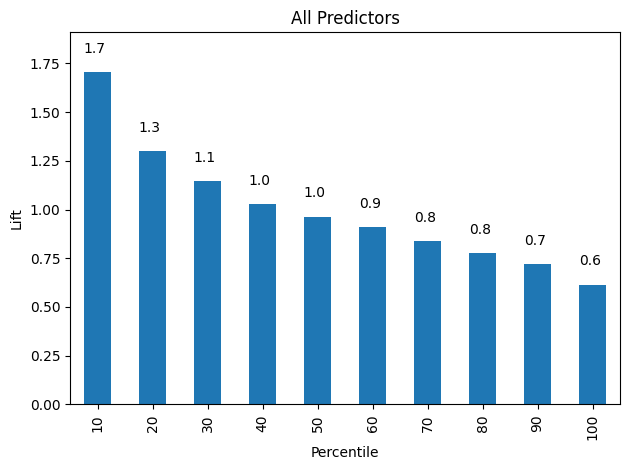

In [292]:
liftChart(resultPredRaw.sort_values(by=['Predicted'], ascending=False).Predicted, labelBars=True, title='All Predictors')
plt.tight_layout()
plt.show()

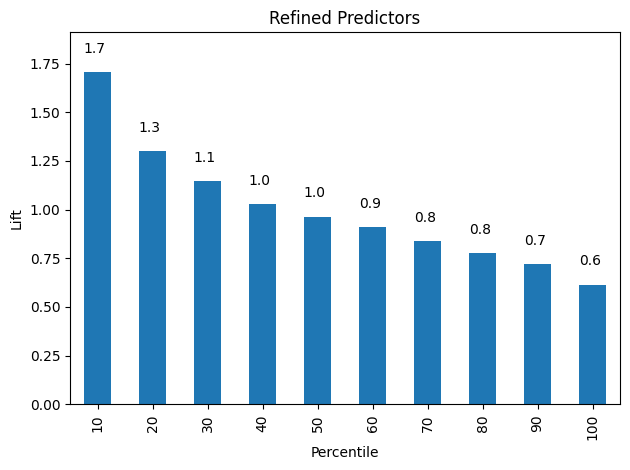

In [293]:
liftChart(resultPredTrain.sort_values(by=['Predicted'], ascending=False).Predicted, labelBars=True, title='Refined Predictors')
plt.tight_layout()
plt.show()

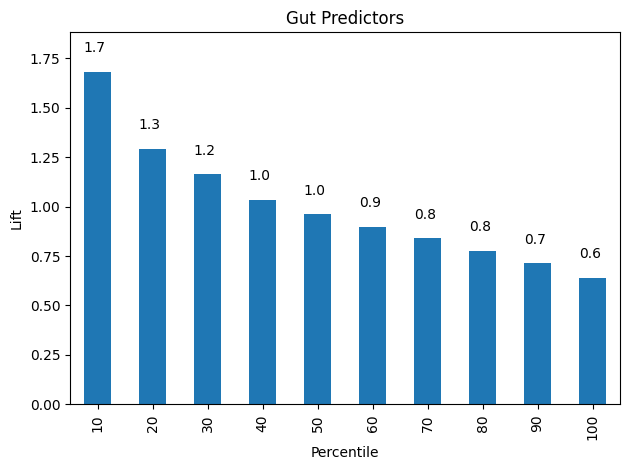

In [294]:
liftChart(resultPredGut.sort_values(by=['Predicted'], ascending=False).Predicted, labelBars=True, title='Gut Predictors')
plt.tight_layout()
plt.show()